## Toxic: Word2Vec

In [1]:
import time

import numpy as np
import tensorflow as tf
import pandas as pd

import utils

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import pandas as pd
df = pd.read_pickle('../data/toxictrain.pkl')
df = df[df['rating']>0]
documents = [''.join(r) for r in df.comment_text]
text = ''.join(documents)

In [3]:
import re

text = re.sub('[^A-Za-z0-9 ]+', '',text)

In [4]:
words = utils.preprocess(text)
print(words[:30])

['i', 'hope', 'your', 'retarded', 'kids', 'get', 'anal', 'raped', 'and', 'murdered', 'for', 'having', 'such', 'a', 'fag', 'as', 'a', 'father', 'im', 'gonna', 'fuck', 'your', 'fat', 'wife', 'and', 'her', 'over', 'the', 'bridge', 'consider']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 753193
Unique words: 6687


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [7]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [8]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [9]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [10]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [11]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [12]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [13]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [14]:
# If the checkpoints directory doesn't exist:
# !mkdir checkpoints

In [15]:
epochs = 500
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "../data/checkpoints/w2v_3.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/500 Iteration: 100 Avg. Training loss: 5.0361 0.3362 sec/batch
Epoch 2/500 Iteration: 200 Avg. Training loss: 4.9380 0.2556 sec/batch
Epoch 33/500 Iteration: 3700 Avg. Training loss: 3.5487 0.0893 sec/batch
Epoch 34/500 Iteration: 3800 Avg. Training loss: 3.5184 0.0654 sec/batch
Epoch 35/500 Iteration: 3900 Avg. Training loss: 3.4997 0.0406 sec/batch
Epoch 36/500 Iteration: 4000 Avg. Training loss: 3.5386 0.0155 sec/batch
Nearest to so: frozen, alternative, neiln, sign, heck, historical, upshut, innocent,
Nearest to go: scientology, intended, scholarly, vandalized, stephen, serbia, je, enjoys,
Nearest to all: agencys, recommend, enforce, itd, burned, minds, contrasfollowing, envy,
Nearest to gay: lifeyou, lifeyoure, mls, daft, niggas, twats, cline, littlemountain5,
Nearest to people: appear, crock, masturbate, chooses, ips, younow, pest, asked,
Nearest to some: flames, breath, mail, authority, flight, rulers, supposedly, trace,
Nearest to am: egg, widely, proposal, userboxes, y

Epoch 65/500 Iteration: 7300 Avg. Training loss: 3.2461 0.0055 sec/batch
Epoch 65/500 Iteration: 7400 Avg. Training loss: 3.2138 0.1613 sec/batch
Epoch 66/500 Iteration: 7500 Avg. Training loss: 3.1546 0.1393 sec/batch
Epoch 67/500 Iteration: 7600 Avg. Training loss: 3.1520 0.1393 sec/batch
Epoch 68/500 Iteration: 7700 Avg. Training loss: 3.1843 0.1103 sec/batch
Epoch 69/500 Iteration: 7800 Avg. Training loss: 3.1536 0.0749 sec/batch
Epoch 70/500 Iteration: 7900 Avg. Training loss: 3.1375 0.0743 sec/batch
Epoch 71/500 Iteration: 8000 Avg. Training loss: 3.1443 0.0294 sec/batch
Nearest to so: alternative, neiln, frozen, mom, innocent, skewed, heck, sign,
Nearest to go: intended, mccain, shake, thati, thugs, scholarly, threats, liz,
Nearest to all: agencys, contrasfollowing, bitchmother, enforce, posters, grandmother, awhile, tw,
Nearest to gay: niggas, goddamned, bit, mls, hellor, twats, littlemountain5, daft,
Nearest to people: appear, masturbate, blame, ips, mommys, crock, pest, youno

Epoch 98/500 Iteration: 11100 Avg. Training loss: 3.0073 0.0643 sec/batch
Epoch 99/500 Iteration: 11200 Avg. Training loss: 2.9979 0.0400 sec/batch
Epoch 100/500 Iteration: 11300 Avg. Training loss: 3.0105 0.0188 sec/batch
Epoch 100/500 Iteration: 11400 Avg. Training loss: 3.0588 0.1538 sec/batch
Epoch 101/500 Iteration: 11500 Avg. Training loss: 3.0028 0.1518 sec/batch
Epoch 102/500 Iteration: 11600 Avg. Training loss: 2.9773 0.1290 sec/batch
Epoch 103/500 Iteration: 11700 Avg. Training loss: 2.9865 0.1075 sec/batch
Epoch 104/500 Iteration: 11800 Avg. Training loss: 2.9573 0.0851 sec/batch
Epoch 105/500 Iteration: 11900 Avg. Training loss: 2.9912 0.0666 sec/batch
Epoch 106/500 Iteration: 12000 Avg. Training loss: 2.9644 0.0413 sec/batch
Nearest to so: neiln, alternative, mom, marcolfuck, heck, innocent, becuase, skewed,
Nearest to go: mccain, intended, thati, threats, shake, thugs, facebook, hsoit,
Nearest to all: agencys, bitchmother, contrasfollowing, grandmother, posters, arrange, 

Epoch 133/500 Iteration: 15100 Avg. Training loss: 2.8923 0.0767 sec/batch
Epoch 134/500 Iteration: 15200 Avg. Training loss: 2.9053 0.0549 sec/batch
Epoch 135/500 Iteration: 15300 Avg. Training loss: 2.8804 0.0322 sec/batch
Epoch 136/500 Iteration: 15400 Avg. Training loss: 2.9132 0.0130 sec/batch
Epoch 136/500 Iteration: 15500 Avg. Training loss: 2.9384 0.1545 sec/batch
Epoch 137/500 Iteration: 15600 Avg. Training loss: 2.8846 0.1463 sec/batch
Epoch 138/500 Iteration: 15700 Avg. Training loss: 2.8752 0.1218 sec/batch
Epoch 139/500 Iteration: 15800 Avg. Training loss: 2.8885 0.1005 sec/batch
Epoch 140/500 Iteration: 15900 Avg. Training loss: 2.8829 0.0800 sec/batch
Epoch 141/500 Iteration: 16000 Avg. Training loss: 2.8931 0.0602 sec/batch
Nearest to so: neiln, marcolfuck, alternative, mom, socialist, personally, mathematics, facts,
Nearest to go: mccain, threats, intended, facebook, republicango, thati, cyprus, shake,
Nearest to all: bitchmother, agencys, march, wash, posters, grandmo

Epoch 168/500 Iteration: 19100 Avg. Training loss: 2.8178 0.0913 sec/batch
Epoch 169/500 Iteration: 19200 Avg. Training loss: 2.8211 0.0706 sec/batch
Epoch 170/500 Iteration: 19300 Avg. Training loss: 2.8148 0.0491 sec/batch
Epoch 171/500 Iteration: 19400 Avg. Training loss: 2.8362 0.0273 sec/batch
Epoch 172/500 Iteration: 19500 Avg. Training loss: 2.8756 0.0082 sec/batch
Epoch 172/500 Iteration: 19600 Avg. Training loss: 2.8332 0.1534 sec/batch
Epoch 173/500 Iteration: 19700 Avg. Training loss: 2.8111 0.1390 sec/batch
Epoch 174/500 Iteration: 19800 Avg. Training loss: 2.8080 0.1213 sec/batch
Epoch 175/500 Iteration: 19900 Avg. Training loss: 2.8091 0.0946 sec/batch
Epoch 176/500 Iteration: 20000 Avg. Training loss: 2.8209 0.0733 sec/batch
Nearest to so: neiln, marcolfuck, mathematics, socialist, personally, dos, facts, algorithm,
Nearest to go: mccain, intended, facebook, republicango, cyprus, threats, thati, coi,
Nearest to all: bitchmother, march, meeting, grandmother, tit, agencys,

Epoch 203/500 Iteration: 23100 Avg. Training loss: 2.7726 0.1102 sec/batch
Epoch 204/500 Iteration: 23200 Avg. Training loss: 2.7841 0.0837 sec/batch
Epoch 205/500 Iteration: 23300 Avg. Training loss: 2.7710 0.0727 sec/batch
Epoch 206/500 Iteration: 23400 Avg. Training loss: 2.7770 0.0622 sec/batch
Epoch 207/500 Iteration: 23500 Avg. Training loss: 2.7739 0.0330 sec/batch
Epoch 208/500 Iteration: 23600 Avg. Training loss: 2.8307 0.0027 sec/batch
Epoch 208/500 Iteration: 23700 Avg. Training loss: 2.7880 0.1532 sec/batch
Epoch 209/500 Iteration: 23800 Avg. Training loss: 2.7569 0.1401 sec/batch
Epoch 210/500 Iteration: 23900 Avg. Training loss: 2.7507 0.1103 sec/batch
Epoch 211/500 Iteration: 24000 Avg. Training loss: 2.7473 0.0868 sec/batch
Nearest to so: marcolfuck, neiln, socialist, mathematics, dos, personally, facts, mom,
Nearest to go: mccain, facebook, intended, cyprus, venture, republicango, children, ma,
Nearest to all: meeting, march, bitchmother, tit, terrorism, hump, grandmot

Epoch 238/500 Iteration: 27100 Avg. Training loss: 2.7307 0.1021 sec/batch
Epoch 239/500 Iteration: 27200 Avg. Training loss: 2.7296 0.0850 sec/batch
Epoch 240/500 Iteration: 27300 Avg. Training loss: 2.7338 0.0652 sec/batch
Epoch 241/500 Iteration: 27400 Avg. Training loss: 2.7372 0.0474 sec/batch
Epoch 242/500 Iteration: 27500 Avg. Training loss: 2.7173 0.0335 sec/batch
Epoch 243/500 Iteration: 27600 Avg. Training loss: 2.7526 0.0131 sec/batch
Epoch 243/500 Iteration: 27700 Avg. Training loss: 2.7728 0.1252 sec/batch
Epoch 244/500 Iteration: 27800 Avg. Training loss: 2.7370 0.1283 sec/batch
Epoch 245/500 Iteration: 27900 Avg. Training loss: 2.7183 0.1224 sec/batch
Epoch 246/500 Iteration: 28000 Avg. Training loss: 2.7585 0.0860 sec/batch
Nearest to so: marcolfuck, neiln, mathematics, socialist, facts, personally, dos, algorithm,
Nearest to go: facebook, intended, knew, mccain, venture, ma, cyprus, children,
Nearest to all: march, meeting, bitchmother, tit, terrorism, nickname, hump, 

Epoch 273/500 Iteration: 31100 Avg. Training loss: 2.7114 0.1154 sec/batch
Epoch 274/500 Iteration: 31200 Avg. Training loss: 2.6938 0.0965 sec/batch
Epoch 275/500 Iteration: 31300 Avg. Training loss: 2.7127 0.0804 sec/batch
Epoch 276/500 Iteration: 31400 Avg. Training loss: 2.6805 0.0596 sec/batch
Epoch 277/500 Iteration: 31500 Avg. Training loss: 2.6996 0.0419 sec/batch
Epoch 278/500 Iteration: 31600 Avg. Training loss: 2.6991 0.0248 sec/batch
Epoch 279/500 Iteration: 31700 Avg. Training loss: 2.7226 0.0084 sec/batch
Epoch 279/500 Iteration: 31800 Avg. Training loss: 2.7423 0.1275 sec/batch
Epoch 280/500 Iteration: 31900 Avg. Training loss: 2.7133 0.1284 sec/batch
Epoch 281/500 Iteration: 32000 Avg. Training loss: 2.6915 0.1059 sec/batch
Nearest to so: marcolfuck, neiln, socialist, facts, mathematics, personally, dudes, dos,
Nearest to go: facebook, knew, mccain, intended, venture, republicango, fack, ma,
Nearest to all: meeting, march, bitchmother, hump, nickname, tit, terrorism, wi

Epoch 308/500 Iteration: 35100 Avg. Training loss: 2.7015 0.1254 sec/batch
Epoch 309/500 Iteration: 35200 Avg. Training loss: 2.6891 0.1094 sec/batch
Epoch 310/500 Iteration: 35300 Avg. Training loss: 2.6754 0.0906 sec/batch
Epoch 311/500 Iteration: 35400 Avg. Training loss: 2.6880 0.0730 sec/batch
Epoch 312/500 Iteration: 35500 Avg. Training loss: 2.6956 0.0544 sec/batch
Epoch 313/500 Iteration: 35600 Avg. Training loss: 2.6955 0.0369 sec/batch
Epoch 314/500 Iteration: 35700 Avg. Training loss: 2.6751 0.0195 sec/batch
Epoch 315/500 Iteration: 35800 Avg. Training loss: 2.7498 0.0045 sec/batch
Epoch 315/500 Iteration: 35900 Avg. Training loss: 2.7033 0.1235 sec/batch
Epoch 316/500 Iteration: 36000 Avg. Training loss: 2.6813 0.1128 sec/batch
Nearest to so: marcolfuck, neiln, mathematics, socialist, childish, dos, facts, dudes,
Nearest to go: facebook, fecesneil, knew, fack, continued, venture, intended, thati,
Nearest to all: meeting, march, hump, bitchmother, wikipedia, terrorism, liar,

Epoch 343/500 Iteration: 39100 Avg. Training loss: 2.7121 0.1269 sec/batch
Epoch 344/500 Iteration: 39200 Avg. Training loss: 2.6629 0.1219 sec/batch
Epoch 345/500 Iteration: 39300 Avg. Training loss: 2.6545 0.1029 sec/batch
Epoch 346/500 Iteration: 39400 Avg. Training loss: 2.6497 0.0843 sec/batch
Epoch 347/500 Iteration: 39500 Avg. Training loss: 2.6618 0.0667 sec/batch
Epoch 348/500 Iteration: 39600 Avg. Training loss: 2.6562 0.0500 sec/batch
Epoch 349/500 Iteration: 39700 Avg. Training loss: 2.6558 0.0318 sec/batch
Epoch 350/500 Iteration: 39800 Avg. Training loss: 2.6501 0.0152 sec/batch
Epoch 350/500 Iteration: 39900 Avg. Training loss: 2.7409 0.1296 sec/batch
Epoch 351/500 Iteration: 40000 Avg. Training loss: 2.6473 0.1252 sec/batch
Nearest to so: marcolfuck, mathematics, neiln, socialist, childish, dudes, facts, publish,
Nearest to go: facebook, fecesneil, continued, venture, knew, fack, cyprus, quotes,
Nearest to all: meeting, march, wikipedia, liar, hump, bitchmother, nicknam

Epoch 379/500 Iteration: 43100 Avg. Training loss: 2.6749 0.0090 sec/batch
Epoch 379/500 Iteration: 43200 Avg. Training loss: 2.6915 0.1334 sec/batch
Epoch 380/500 Iteration: 43300 Avg. Training loss: 2.6445 0.1225 sec/batch
Epoch 381/500 Iteration: 43400 Avg. Training loss: 2.6378 0.1066 sec/batch
Epoch 382/500 Iteration: 43500 Avg. Training loss: 2.6418 0.0860 sec/batch
Epoch 383/500 Iteration: 43600 Avg. Training loss: 2.6296 0.0651 sec/batch
Epoch 384/500 Iteration: 43700 Avg. Training loss: 2.6551 0.0472 sec/batch
Epoch 385/500 Iteration: 43800 Avg. Training loss: 2.6167 0.0318 sec/batch
Epoch 386/500 Iteration: 43900 Avg. Training loss: 2.6774 0.0106 sec/batch
Epoch 386/500 Iteration: 44000 Avg. Training loss: 2.6966 0.1260 sec/batch
Nearest to so: marcolfuck, socialist, mathematics, childish, publish, facts, neiln, algorithm,
Nearest to go: fecesneil, facebook, continued, fack, knew, republicango, venture, mccain,
Nearest to all: meeting, march, liar, hump, wikipedia, bitchmothe

Epoch 414/500 Iteration: 47100 Avg. Training loss: 2.6215 0.0210 sec/batch
Epoch 415/500 Iteration: 47200 Avg. Training loss: 2.6965 0.0073 sec/batch
Epoch 415/500 Iteration: 47300 Avg. Training loss: 2.6680 0.1712 sec/batch
Epoch 416/500 Iteration: 47400 Avg. Training loss: 2.6140 0.1538 sec/batch
Epoch 417/500 Iteration: 47500 Avg. Training loss: 2.6245 0.1126 sec/batch
Epoch 418/500 Iteration: 47600 Avg. Training loss: 2.6486 0.0919 sec/batch
Epoch 419/500 Iteration: 47700 Avg. Training loss: 2.6358 0.0727 sec/batch
Epoch 420/500 Iteration: 47800 Avg. Training loss: 2.6262 0.0466 sec/batch
Epoch 421/500 Iteration: 47900 Avg. Training loss: 2.6312 0.0268 sec/batch
Epoch 422/500 Iteration: 48000 Avg. Training loss: 2.6766 0.0077 sec/batch
Nearest to so: marcolfuck, mathematics, childish, publish, dudes, socialist, neiln, algorithm,
Nearest to go: fecesneil, facebook, fack, knew, continued, venture, undid, intended,
Nearest to all: meeting, march, liar, hump, wikipedia, arrange, bitchm

Epoch 449/500 Iteration: 51100 Avg. Training loss: 2.6310 0.0385 sec/batch
Epoch 450/500 Iteration: 51200 Avg. Training loss: 2.6257 0.0183 sec/batch
Epoch 450/500 Iteration: 51300 Avg. Training loss: 2.6635 0.1537 sec/batch
Epoch 451/500 Iteration: 51400 Avg. Training loss: 2.6217 0.1524 sec/batch
Epoch 452/500 Iteration: 51500 Avg. Training loss: 2.6172 0.1330 sec/batch
Epoch 453/500 Iteration: 51600 Avg. Training loss: 2.6223 0.1097 sec/batch
Epoch 454/500 Iteration: 51700 Avg. Training loss: 2.6168 0.0856 sec/batch
Epoch 455/500 Iteration: 51800 Avg. Training loss: 2.6211 0.0640 sec/batch
Epoch 456/500 Iteration: 51900 Avg. Training loss: 2.6430 0.0421 sec/batch
Epoch 457/500 Iteration: 52000 Avg. Training loss: 2.6092 0.0215 sec/batch
Nearest to so: marcolfuck, childish, publish, mathematics, facts, algorithm, socialist, dudes,
Nearest to go: fecesneil, facebook, fack, knew, continued, venture, undid, mccain,
Nearest to all: meeting, march, liar, hump, wikipedia, guts, bollocksbol

Epoch 484/500 Iteration: 55100 Avg. Training loss: 2.6301 0.0538 sec/batch
Epoch 485/500 Iteration: 55200 Avg. Training loss: 2.6071 0.0329 sec/batch
Epoch 486/500 Iteration: 55300 Avg. Training loss: 2.6570 0.0129 sec/batch
Epoch 486/500 Iteration: 55400 Avg. Training loss: 2.6531 0.1482 sec/batch
Epoch 487/500 Iteration: 55500 Avg. Training loss: 2.5914 0.1498 sec/batch
Epoch 488/500 Iteration: 55600 Avg. Training loss: 2.6013 0.1316 sec/batch
Epoch 489/500 Iteration: 55700 Avg. Training loss: 2.6171 0.0985 sec/batch
Epoch 490/500 Iteration: 55800 Avg. Training loss: 2.6136 0.0765 sec/batch
Epoch 491/500 Iteration: 55900 Avg. Training loss: 2.6095 0.0550 sec/batch
Epoch 492/500 Iteration: 56000 Avg. Training loss: 2.5948 0.0352 sec/batch
Nearest to so: marcolfuck, publish, childish, mathematics, socialist, algorithm, dos, dudes,
Nearest to go: fecesneil, fack, facebook, continued, knew, green, venture, resist,
Nearest to all: meeting, liar, march, hump, wikipedia, tit, guts, bollocks

In [ ]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('../data/checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from ../data/checkpoints/w2v_3.ckpt


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

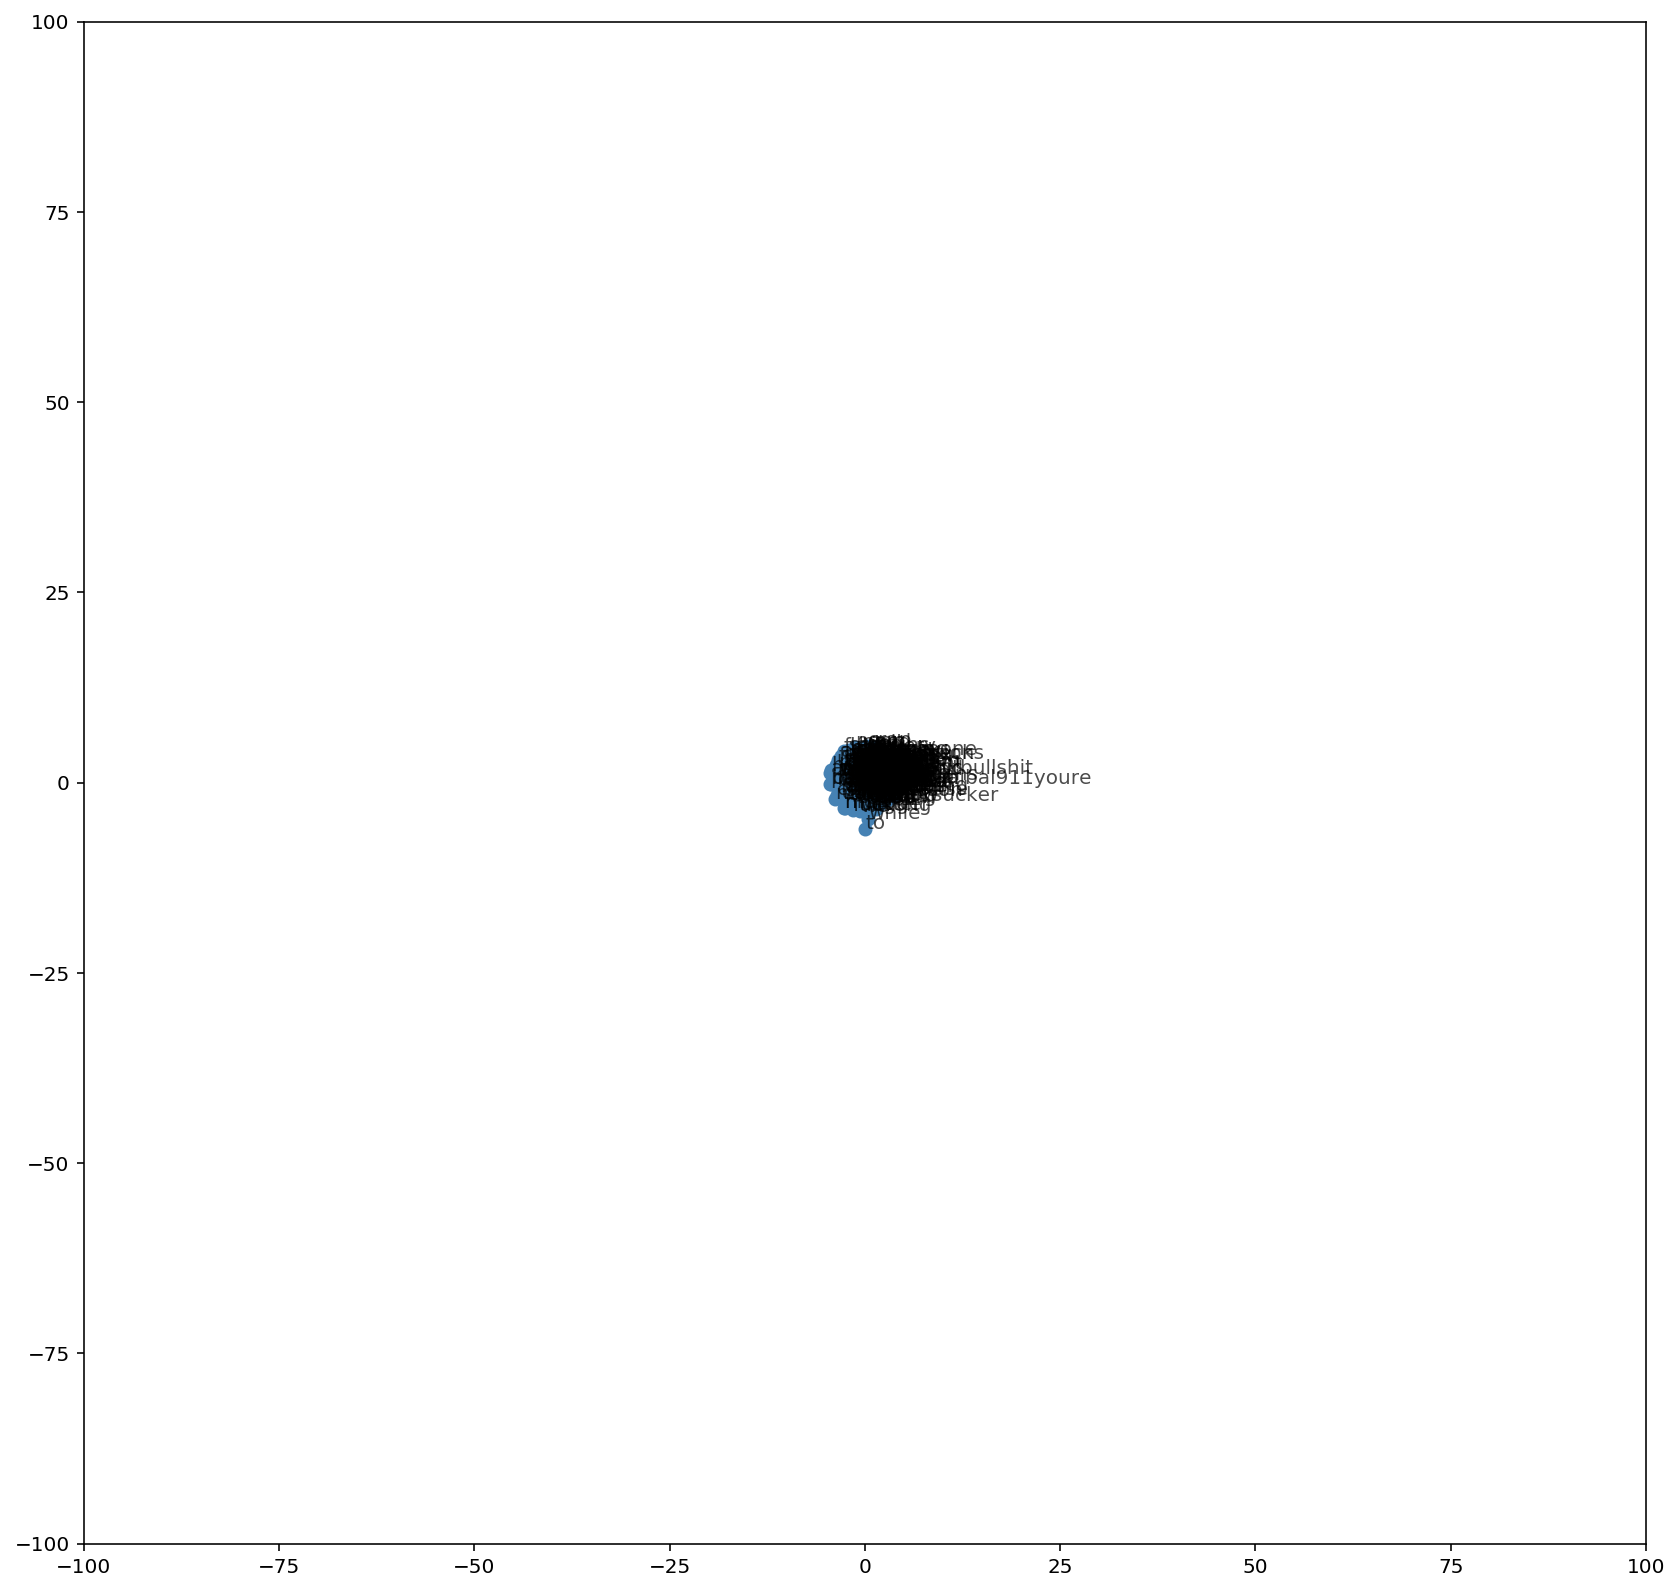

In [ ]:
ax_set = 100.0
fig, ax = plt.subplots(figsize=(14, 14))
ax.axis([-ax_set,ax_set, -ax_set,ax_set])
ax = fig.gca()
ax.set_autoscale_on(False)

for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)